### Generate RF Features
- notebook to load data (currently: DroneDetect dataset)
- generate RF-based features: PSD, spectrograms in array form


In [1]:
import os
import numpy as np
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
import os
from sklearn.model_selection import train_test_split
from spafe.features.lfcc import lfcc
import spafe.utils.vis as vis
from scipy.signal import get_window
import scipy.fftpack as fft
from scipy import signal
import matplotlib.pyplot as plt
from datetime import date
from tqdm import tqdm

In [2]:
# Data paths

# 1. DroneDetect
main_folder = '/home/ltindall/data/DroneDetect/DroneDetect_V2/' # data path on mp-gpu-desktop06
sub_folders = os.listdir(main_folder)

# Dataset Info
fs = 60e6 #60 MHz
bandwidth = 20e6 # 28MHz
center_freq = 2.43e9

# 2. DroneRF
# main_folder = '/Users/kzhou/Documents/DroneRF Data/All/converted/'
# high_freq_files = os.listdir(data_folder+'High/')
# low_freq_files = os.listdir(data_folder+'Low/')

# high_freq_files.sort()
# low_freq_files.sort()
# fs = 40e6 #40 MHz


# 3. Collected Data
# main_folder = '/home/kzhou/Data/S3/'
# subfolders = ['leesburg_worker1', 'pdx_worker1']
# TODO: how to load this


In [3]:
# Load data for Drone Detect
# input: file_path
#        t_seg: duration of the segment in miliseconds
def load_data(file_path, t_seg):
    f = open(file_path, "rb")                                        # open file
    data = np.fromfile(f, dtype="float32",count=240000000)      # read the data into numpy array
    data = data.astype(np.float32).view(np.complex64)           # view as complex
    data_norm = (data-np.mean(data))/(np.sqrt(np.var(data)))    # normalise
    # decide on segment lengths
    len_seg = int(t_seg/1e3*fs)
    n_segs = (len(data_norm))//len_seg
    n_keep = n_segs*len_seg
    newarr = np.array_split(data_norm[:n_keep], n_segs)                  # split the array, 100 will equate to a sample length of 20ms
    # 10 Splits into 200ms chunks
    return newarr, data_norm

In [4]:
## DATA SAVING FUNCTIONS

# save function to save image to file
def save_spec_image(folder_path, cond_folder, DRONE, COND, INT, FIn, counter, f, t, Sxx):
    plt.clf()
    plt.pcolormesh(t, f, Sxx, cmap='Greys', vmin=Sxx.min(), vmax=Sxx.max())
    full_img_path = folder_path+cond_folder+DRONE+'_'+COND+'_'+INT+'_'+FIn+'_'+str(counter)+'.jpg'
    plt.savefig(full_img_path)

def save_psd_image(folder_path, cond_folder, DRONE, COND, INT, FIn, counter, f, PSD):
    plt.clf()
    plt.plot(f, PSD, 'k')
    full_img_path = folder_path+cond_folder+DRONE+'_'+COND+'_'+INT+'_'+FIn+'_'+str(counter)+'.jpg'
    plt.savefig(full_img_path)    

def save_array(folder_path, feat, DRONES, CONDS, INTS, feat_name, int_name):
    Xs_arr = np.array(feat)
    
    # labels
    y_drones_arr = np.array(DRONES)
    y_conds_arr = np.array(CONDS)
    y_ints_arr = np.array(INTS)

    data_save = {'feat': Xs_arr, 'drones': y_drones_arr, 'conds': y_conds_arr, 'ints': y_ints_arr}
#     return data_save

#     #Save data
    date_string = date.today()
    fp = folder_path+int_name+"_"+feat_name+"_"+str(n_per_seg)
    print(fp)
    np.save(fp, data_save)

In [ ]:
# Labels & Features

n_per_seg = 256 # length of each segment (powers of 2)
win_type = 'hamming' # make ends of each segment match
t_seg = 100 # sample length in milliseconds

# data saving folders
features_folder = '../Features/'
date_string = date.today()
# folder naming: ARR_FEAT_NFFT_SAMPLELENGTH_DATE
img_psd_folder=  "IMG_PSD_"+str(n_per_seg)+"_"+str(t_seg)+"_"+str(date_string)+"/"
img_spec_folder = "IMG_SPEC_"+str(n_per_seg)+"_"+str(t_seg)+"_"+str(date_string)+"/"
arr_spec_folder = "ARR_SPEC_"+str(n_per_seg)+"_"+str(t_seg)+"_"+str(date_string)+"/"
arr_psd_folder = "ARR_PSD_"+str(n_per_seg)+"_"+str(t_seg)+"_"+str(date_string)+"/"

try:
#     os.mkdir(features_folder+img_psd_folder) # just save images for now
#     os.mkdir(features_folder+img_spec_folder)
    os.mkdir(features_folder+arr_spec_folder)
    os.mkdir(features_folder+arr_psd_folder)
except:
    print('folder already exists')

# loop through all files
for sf in ['WIFI', 'BLUE', 'BOTH', 'CLEAN']: # options: ['WIFI', 'BLUE', 'BOTH', 'CLEAN']
    print('current folder: ', sf)

    drone_folders = os.listdir(main_folder+sf+'/')
    for df in drone_folders:
        print('     subfolder:', df)
        # reset lists -  to save memory
        DRONES = []
        CONDS =[]
        INTS = [] # interferences: 00 for a clean signal, 01 for Bluetooth only, 10 for Wi-Fi only and 11 for Bluetooth and Wi-Fi interference concurrently.

        # features
        F_PSD = []
        F_PSD_freq = []
        
        F_SPEC = []
        F_SPEC_freq = []
        F_SPEC_time = []
    
        files = os.listdir(main_folder+sf+'/'+df+'/')
        
        drone_name = df[:3]
        cond_name = df[4:]
        
        for fi in tqdm(files):
            d_split, _ = load_data(main_folder+sf+'/'+df+'/'+fi, t_seg)
            fi_number = fi[-6:-4]
            int_name = fi[4:6]
            for i in range(len(d_split)): # 100 split samples of 20 milliseconds each
                
                d_real = abs(d_split[i])

                # save labels
                DRONES.append(drone_name)
                CONDS.append(cond_name)
                INTS.append(int_name)

                # calculate PSD
                fpsd, Pxx_den = signal.welch(d_real, fs, window=win_type, nperseg=n_per_seg)
                F_PSD.append(Pxx_den)
                F_PSD_freq.append(fpsd)

                # calculate spectrogram
                fspec, t, Sxx = signal.spectrogram(d_real, fs, window=win_type, nperseg=n_per_seg)
                F_SPEC.append(Sxx)
                F_SPEC_freq.append(fspec)
                F_SPEC_time.append(t)
                
                # save the images 
#                 save_spec_image(features_folder, img_spec_folder, drone_name, 
#                                 cond_name, int_name, fi_number, i, fspec, t, Sxx)
                
#                 # save the images 
#                 save_psd_image(features_folder, img_psd_folder, drone_name, 
#                                 cond_name, int_name, fi_number, i, fpsd, Pxx_den)
                
        # save data array
        save_array(features_folder+arr_spec_folder, F_SPEC, DRONES, CONDS, INTS, 'SPEC'+"_"+df, sf)
        save_array(features_folder+arr_psd_folder, F_PSD, DRONES, CONDS, INTS, 'PSD'+"_"+df, sf)

    

current folder:  WIFI
     subfolder: AIR_FY


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.66s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_AIR_FY_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_AIR_FY_256
     subfolder: MP1_ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.28s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_MP1_ON_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_MP1_ON_256
     subfolder: MIN_FY


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.34s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_MIN_FY_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_MIN_FY_256
     subfolder: PHA_FY


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.33s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_PHA_FY_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_PHA_FY_256
     subfolder: MP2_ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.28s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_MP2_ON_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_MP2_ON_256
     subfolder: MIN_HO


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.24s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_MIN_HO_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_MIN_HO_256
     subfolder: AIR_HO


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.30s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_AIR_HO_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_AIR_HO_256
     subfolder: MP1_FY


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.34s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_MP1_FY_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_MP1_FY_256
     subfolder: DIS_FY


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.29s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_DIS_FY_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_DIS_FY_256
     subfolder: MIN_ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.23s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_MIN_ON_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_MIN_ON_256
     subfolder: DIS_ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.46s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_DIS_ON_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_DIS_ON_256
     subfolder: INS_FY


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.28s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_INS_FY_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_INS_FY_256
     subfolder: INS_HO


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.38s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_INS_HO_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_INS_HO_256
     subfolder: MP2_FY


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.27s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_MP2_FY_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_MP2_FY_256
     subfolder: MP1_HO


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.28s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_MP1_HO_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_MP1_HO_256
     subfolder: MP2_HO


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.31s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_MP2_HO_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_MP2_HO_256
     subfolder: PHA_ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.26s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_PHA_ON_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_PHA_ON_256
     subfolder: PHA_HO


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.41s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_PHA_HO_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_PHA_HO_256
     subfolder: INS_ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.21s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_INS_ON_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_INS_ON_256
     subfolder: AIR_ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.29s/it]


../Features/ARR_SPEC_256_100_2022-07-05/WIFI_SPEC_AIR_ON_256
../Features/ARR_PSD_256_100_2022-07-05/WIFI_PSD_AIR_ON_256
current folder:  BLUE
     subfolder: AIR_FY


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.23s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_AIR_FY_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_AIR_FY_256
     subfolder: MP1_ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.42s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_MP1_ON_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_MP1_ON_256
     subfolder: MIN_FY


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.29s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_MIN_FY_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_MIN_FY_256
     subfolder: PHA_FY


0it [00:00, ?it/s]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_PHA_FY_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_PHA_FY_256
     subfolder: MP2_ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.30s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_MP2_ON_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_MP2_ON_256
     subfolder: MIN_HO


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.31s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_MIN_HO_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_MIN_HO_256
     subfolder: AIR_HO


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.32s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_AIR_HO_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_AIR_HO_256
     subfolder: MP1_FY


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.38s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_MP1_FY_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_MP1_FY_256
     subfolder: DIS_FY


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.39s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_DIS_FY_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_DIS_FY_256
     subfolder: MIN_ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.41s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_MIN_ON_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_MIN_ON_256
     subfolder: DIS_ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.36s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_DIS_ON_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_DIS_ON_256
     subfolder: INS_FY


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.36s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_INS_FY_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_INS_FY_256
     subfolder: INS_HO


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.37s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_INS_HO_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_INS_HO_256
     subfolder: MP2_FY


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.38s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_MP2_FY_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_MP2_FY_256
     subfolder: MP1_HO


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.33s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_MP1_HO_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_MP1_HO_256
     subfolder: MP2_HO


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.43s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_MP2_HO_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_MP2_HO_256
     subfolder: PHA_ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.34s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_PHA_ON_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_PHA_ON_256
     subfolder: PHA_HO


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.44s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_PHA_HO_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_PHA_HO_256
     subfolder: INS_ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.48s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_INS_ON_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_INS_ON_256
     subfolder: AIR_ON


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.38s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BLUE_SPEC_AIR_ON_256
../Features/ARR_PSD_256_100_2022-07-05/BLUE_PSD_AIR_ON_256
current folder:  BOTH
     subfolder: AIR_FY


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.31s/it]


../Features/ARR_SPEC_256_100_2022-07-05/BOTH_SPEC_AIR_FY_256
../Features/ARR_PSD_256_100_2022-07-05/BOTH_PSD_AIR_FY_256
     subfolder: MP1_ON


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:20<00:05,  5.26s/it]

## Load Files test

In [32]:
from helper_functions import *

In [47]:
feat_folder = '../Features/'
feat_name = 'PSD'
datestr = '2022-06-29'
n_per_seg = 1024
interferences = ['WIFI']
Xs_arr, y_arr = load_features_arr(feat_folder, feat_name, datestr, n_per_seg, interferences)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1765.57it/s]


In [48]:
Xs_arr.shape

(1000, 513)

## Plot as images test

In [49]:
import importlib
import helper_functions
importlib.reload(helper_functions)

<module 'helper_functions' from '/home/kzhou/main/RFClassification/helper_functions.py'>

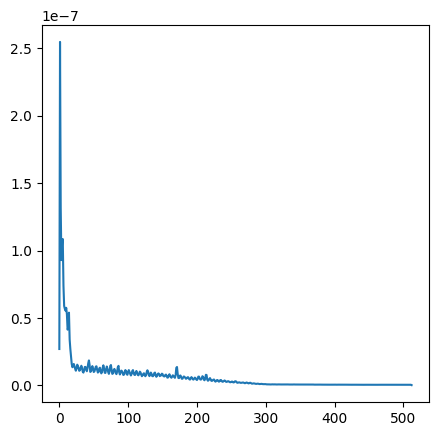

In [50]:
sample_to_plot = 0
helper_functions.plot_image(Xs_arr[sample_to_plot], dim=(5,5), dpi=100)

### To visualize images

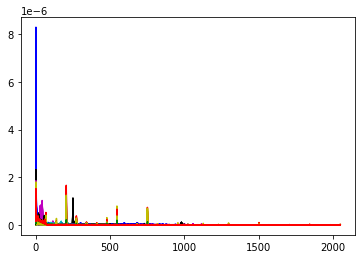

In [7]:
# # plot for each type of drone
# X_norm = Xs
# for n in range(len(Xs_arr)):
#     if DRONES[n] == 'AIR':
#         c = 'r'
#     elif DRONES[n] == 'DIS':
#         c = 'b'
#     elif DRONES[n] == 'INS':
#         c = 'g'
#     elif DRONES[n] == 'MIN':
#         c = 'c'
#     elif DRONES[n] == 'MP1':
#         c = 'm'
#     elif DRONES[n] == 'MP2':
#         c = 'k'
#     elif DRONES[n] == 'PHA':
#         c = 'y'
    
#     # normalize it
# #     X_norm[n] = Xs[n]/max(Xs[n])
#     plt.plot(Xs[n],color=c)